# Natural Language Processing with Disaster Tweets

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Different things to keep in mind compare to main.ipynb:
- Use all the columns
- Processing pipeline (lowercasing, stopword removal, punctuation removal, lemmatization, tokenization, and padding)
- Use ML classification algorithms

In [1]:
%pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import numpy as np

import contractions

import os

import re

import tensorflow as tf

import matplotlib.pyplot as plt

from textblob import TextBlob

from transformers import BertTokenizer, TFBertForSequenceClassification, RobertaTokenizer, TFRobertaForSequenceClassification

from sklearn.model_selection import train_test_split

from datetime import datetime

In [3]:
kaggle_run = True
if kaggle_run:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
    test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
else:
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')
    submission = pd.read_csv('data/sample_submission.csv')

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Preprocessing

In [4]:
def expand_contractions(text):
    return contractions.fix(text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def correct_spelling(text):
    return str(TextBlob(text).correct())

def preprocessing(df):
    df.fillna('', inplace=True)
        
    df['combined_text'] = df['keyword'] + ' ' + df['text']
    df = df.drop(['id','keyword','location','text'], axis=1)
        
    df['combined_text'] = df['combined_text'].str.lower()
    df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'http[s]?://\S+|www\.\S+','', x))

    df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'@[^ \t\n\r\f\v]+', '', x))
    df['combined_text'] = df['combined_text'].str.replace(' @ ', ' at ', regex=False)

    df['combined_text'] = df['combined_text'].apply(expand_contractions)
    
    df['combined_text'] = df['combined_text'].apply(remove_numbers)
    
    df['combined_text'] = df['combined_text'].str.replace('#', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace('"', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace(' "', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace(' " ', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace('" ', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace(' | ', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace('+', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace('*', '', regex=False)
    df['combined_text'] = df['combined_text'].str.replace(' via ', '', regex=False)

    
    return df

In [5]:
train = preprocessing(train)
test = preprocessing(test)

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['combined_text'].tolist(), 
    train['target'].tolist(), 
    test_size=0.2, 
    random_state=42
)

#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased') # First run ('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

train_encodings = tokenizer(
    train_texts,
    padding=True,
    truncation=True, # Cuts off the input text if it exceeds the model maximum input length.
    return_tensors='tf'
)

# Get data in TF format
train_dataset = tf.data.Dataset.from_tensor_slices(( 
    dict(train_encodings),
    train_labels
))

# Schuffle the data and group them in amount of 16 in batches for efficient use.. 
train_dataset = train_dataset.shuffle(len(train_texts)).batch(16)

val_encodings = tokenizer(
    val_texts,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

val_dataset = val_dataset.batch(16)

#model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
model = TFRobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss during training
    patience=3,  # Allow 3 epochs with no improvement before stopping
    restore_best_weights=True  # Restore the model's weights from the epoch with the lowest validation loss
)

history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10
    #callbacks=[early_stopping]
)

test_encodings = tokenizer(
    test['combined_text'].tolist(),
    padding=True,
    truncation=True,
    return_tensors='tf'
)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))
test_dataset = test_dataset.batch(16)

predictions = model.predict(test_dataset)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1725553052.310920     114 service.cc:145] XLA service 0x79ea6bdb71d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725553052.310984     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725553052.310988     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725553052.600584     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 [==============================] - 493s 864ms/step - loss: 0.4633 - accuracy: 0.7895 - val_loss: 0.3978 - val_accuracy: 0.8418
Epoch 2/10
381/381 [==============================] - 305s 800ms/step - loss: 0.3652 - accuracy: 0.8529 - val_loss: 0.3984 - val_accuracy: 0.8345
Epoch 3/10
381/381 [==============================] - 304s 798ms/step - loss: 0.3018 - accuracy: 0.8829 - val_loss: 0.4311 - val_accuracy: 0.8418
Epoch 4/10
381/381 [==============================] - 304s 798ms/step - loss: 0.2507 - accuracy: 0.9087 - val_loss: 0.4341 - val_accuracy: 0.8345
Epoch 5/10
381/381 [==============================] - 304s 799ms/step - loss: 0.2003 - accuracy: 0.9282 - val_loss: 0.5656 - val_accuracy: 0.8207
Epoch 6/10
381/381 [==============================] - 304s 799ms/step - loss: 0.1564 - accuracy: 0.9406 - val_loss: 0.5580 - val_accuracy: 0.8286
Epoch 7/10
381/381 [==============================] - 304s 799ms/step - loss: 0.1159 - accuracy: 0.9563 - val_loss: 0.7047 - val_accura

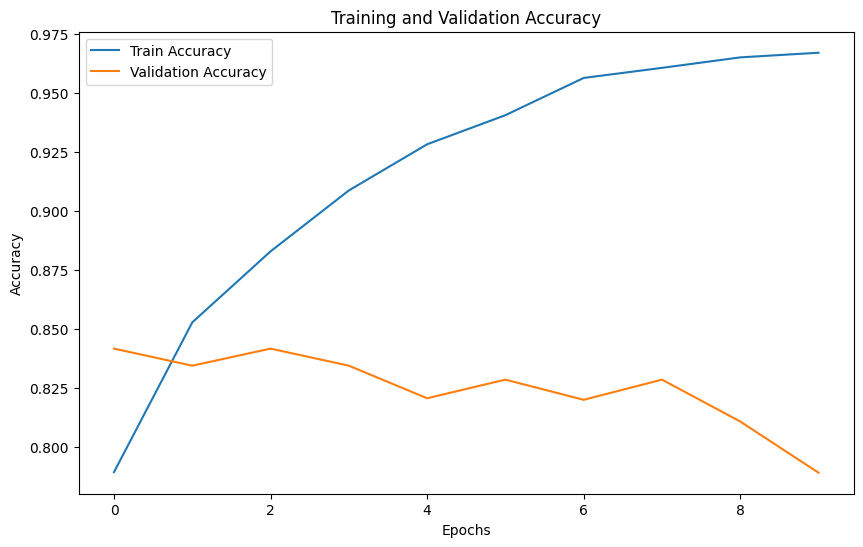

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Prediction on new data 

In [8]:
predictions = tf.nn.softmax(predictions.logits, axis=-1)
predictions = tf.argmax(predictions, axis=1).numpy()

## Prepare upload

In [9]:
choosen_model_name = 'roberta_e10'
choosen_model_predictions = predictions

now = datetime.now()
date_time_str = now.strftime("%Y%m%d_%H%M%S")

if kaggle_run:
    submission = pd.DataFrame({
        'id': pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')['id'],
        'target': choosen_model_predictions
    })

    print(submission['target'].tolist())
    submission.to_csv(f'/kaggle/working/submission.csv', index=False)
else:
    submission = pd.DataFrame({
        'id': pd.read_csv('data/test.csv')['id'],
        'target': choosen_model_predictions
    })
    submission.to_csv(f'output/submission_{choosen_model_name}_{date_time_str}.csv', index=False)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 